In [1]:
from astropy.io import fits
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D,SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
#plt.gray()
galaxy_name = 'NGC 2366'
'''
#entered by hand ------------------------------------------------------------------------------------------------------------------------------------------------
center_v = [430 , 500]
center_b = [430 , 504]
center_u = [380 , 530]
center = center_v
'''
box_size = 200
window_size = (40, 40)
U_exp = 1800
B_exp = 1200
V_exp = 600
exp = [U_exp,B_exp,V_exp]

# import files----------------------------------------------------------------------------------------------------------------------------------------------------
light_file_u = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data/NGC 2366/n2366u.fits")
light_u = light_file_u[0].data

light_file_b = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data/NGC 2366/n2366b.fits")
light_b = light_file_b[0].data

light_file_v = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data/NGC 2366/n2366v.fits")
light_v = light_file_v[0].data

box_u = (100 , 100)
box_b = (130 , 130)
box_v = (170 , 170)

lights = [light_u,light_b,light_v]
boxes = [box_u,box_b,box_v]
filters = ["U" , "B" , "V"]

ModuleNotFoundError: No module named 'little_things_functions'

In [2]:
'''
def mag_correction(mag_map, mag_map_BV, correction_parameters, opacity, image_offset_V = (0, 0)):
    # offsetting images and correcting
    Dx, Dy = image_offset_V[0], image_offset_V[1]
    x1, y1 = len(mag_map_BV[0]), len(mag_map_BV)
    x2, y2 = len(mag_map[0]), len(mag_map)
    x3, y3 = x1 - Dx, y1 - Dy
    if x2 < x3:
        x3 = x2
    if y2 < y3:
        y3 = y2
    mag_map_corrected = np.zeros([y3, x3])
    for y in range(y3):
        for x in range(x3):
            mag_map_corrected[y][x] = mag_map[y][x] - mag_map_BV[y + Dy][x + Dx] * correction_parameters[2] - correction_parameters[0] - correction_parameters[1] * opacity
    return mag_map_corrected
B_map_c = V_map + mag_correction(lights[2], lights[1], correction_parameters = (0, 0, 0, 0), 0,image_offset_V = ())
'''

'\ndef mag_correction(mag_map, mag_map_BV, correction_parameters, opacity, image_offset_V = (0, 0)):\n    # offsetting images and correcting\n    Dx, Dy = image_offset_V[0], image_offset_V[1]\n    x1, y1 = len(mag_map_BV[0]), len(mag_map_BV)\n    x2, y2 = len(mag_map[0]), len(mag_map)\n    x3, y3 = x1 - Dx, y1 - Dy\n    if x2 < x3:\n        x3 = x2\n    if y2 < y3:\n        y3 = y2\n    mag_map_corrected = np.zeros([y3, x3])\n    for y in range(y3):\n        for x in range(x3):\n            mag_map_corrected[y][x] = mag_map[y][x] - mag_map_BV[y + Dy][x + Dx] * correction_parameters[2] - correction_parameters[0] - correction_parameters[1] * opacity\n    return mag_map_corrected\nB_map_c = V_map + mag_correction(lights[2], lights[1], correction_parameters = (0, 0, 0, 0), 0,image_offset_V = ())\n'

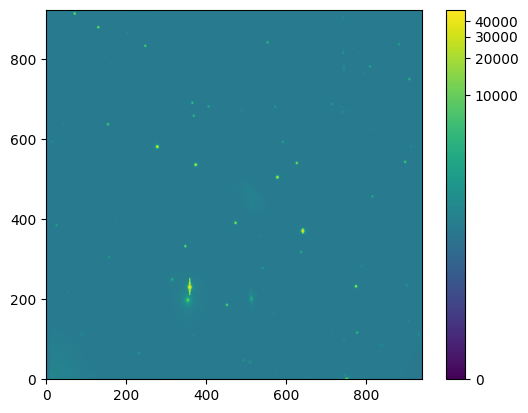

(924, 939) (924, 939) (924, 939)


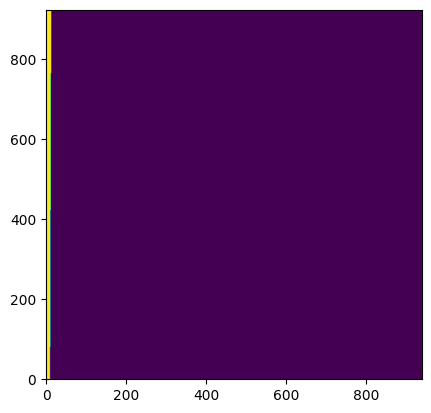

In [3]:
import astroalign as aa
target_fixed = lights[2].byteswap().newbyteorder('N')
source_fixed_U = lights[0].byteswap().newbyteorder('N')
source_fixed_B = lights[1].byteswap().newbyteorder('N')
norm = ImageNormalize(vmin=0., stretch=LogStretch())
registered_image_B, footprint_B = aa.register(source_fixed_B, target_fixed)
registered_image_U, footprint_U = aa.register(source_fixed_U, target_fixed)

plt.imshow(registered_image_U/2 + target_fixed/2, origin = "lower" , alpha = 1 , norm = norm)
plt.colorbar()
plt.show()
plt.imshow(footprint_U,origin="lower")
print(np.shape(registered_image_U),np.shape(registered_image_B),np.shape(lights[2]))
lights[0] = registered_image_U
lights[1] = registered_image_B

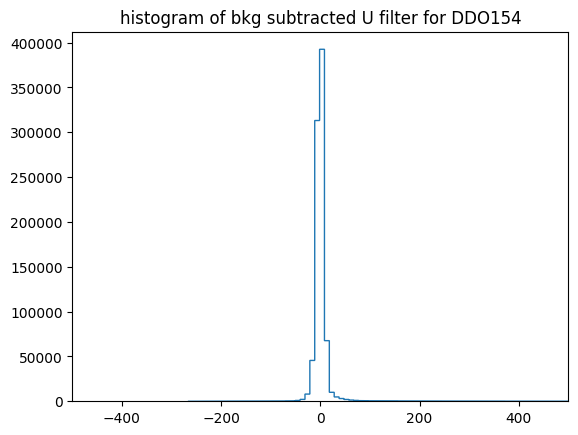

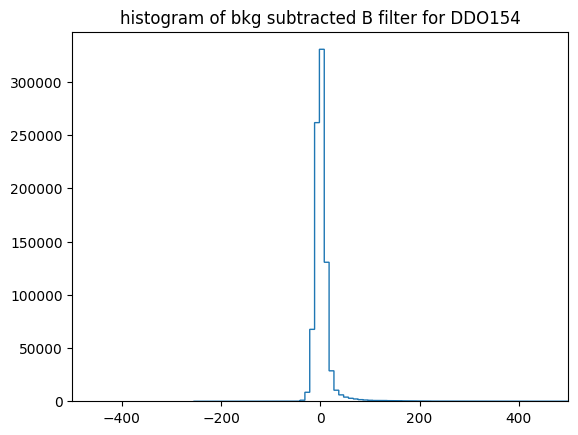

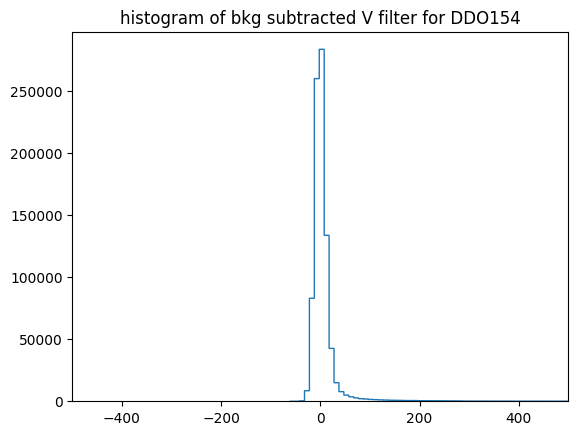

In [4]:
bkg_corrected = []
for i in range(0 , len(lights)): 
# create background------------------------------------------------------------------------------------------------------------------------------------------------
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = SExtractorBackground()
    bkg = Background2D(lights[i], boxes[i] , filter_size=(3, 3),
    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    data = lights[i] - bkg.background
    bkg_corrected.append(data)
    plt.figure()
    counts, bins = np.histogram(data, 5000)
    plt.stairs(counts, bins)
    plt.xlim([-500, 500])
    plt.title("histogram of bkg subtracted %s filter for %s" %(filters[i] , galaxy_name))
    plt.show()


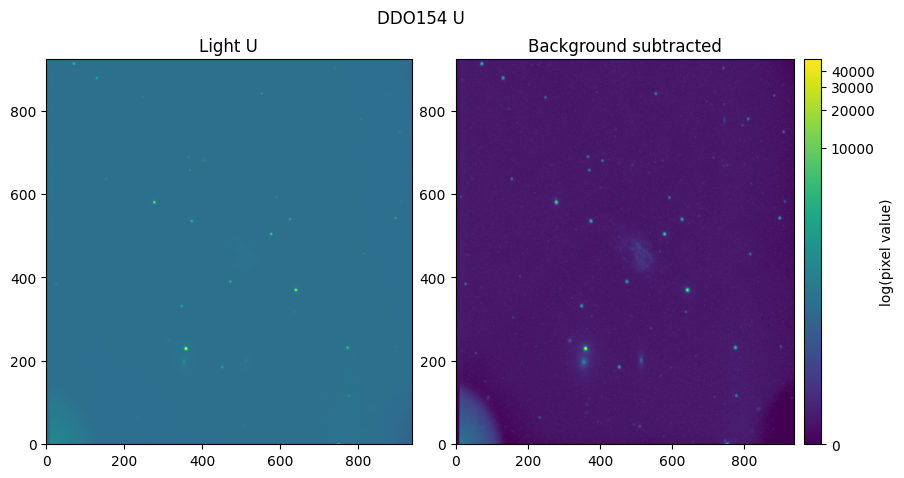

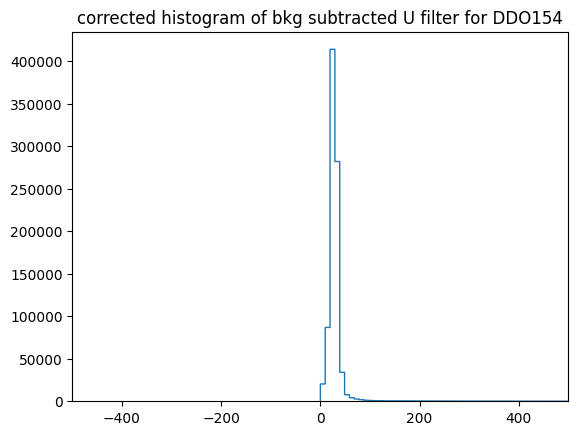

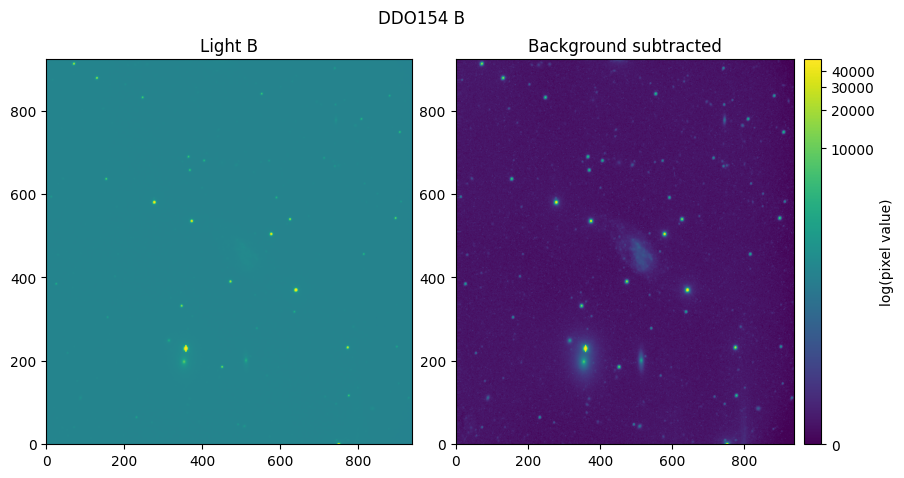

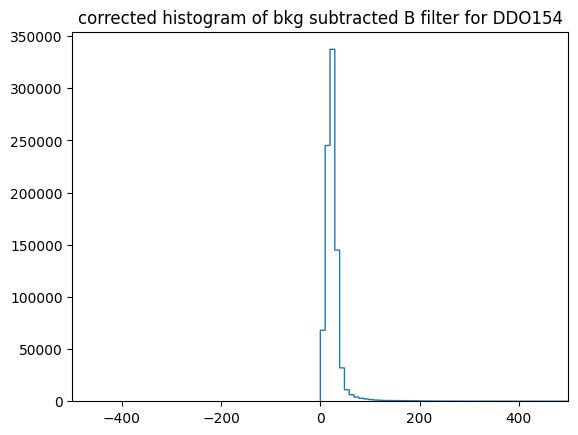

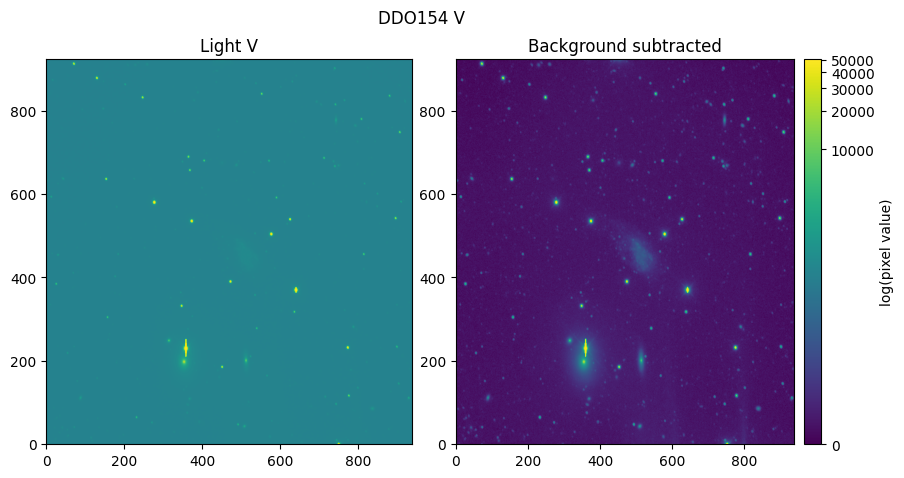

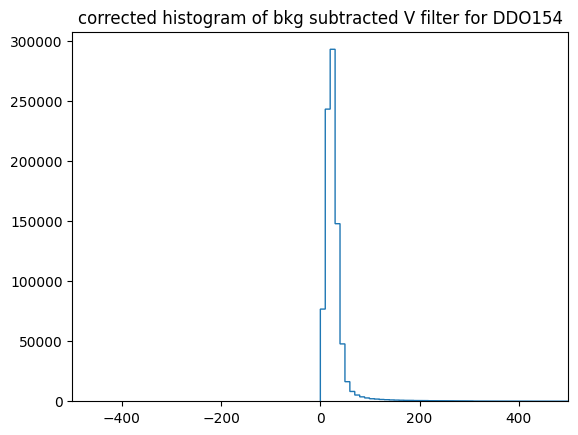

0.00036889660327688034


In [5]:
i_list = []
for data in bkg_corrected:
    min_value = int(np.min(data))
    Acceptable_i = []
    for i in range(0,-min_value):
        newdata = data + i
        num_negative_values = np.sum(newdata < 0)
        ratio = num_negative_values / newdata.size
        if ratio < 0.01:
            Acceptable_i.append(i)
        else:
            i = i+1
    min_i = np.min(Acceptable_i)
    i_list.append(min_i)

corrected_lights = []
for i in range(0 , len(lights)): 
# create background------------------------------------------------------------------------------------------------------------------------------------------------
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = SExtractorBackground()
    bkg = Background2D(lights[i], boxes[i] , filter_size=(3, 3),
    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    corrected_light = lights[i] - bkg.background + i_list[i]
    corrected_light[corrected_light <= 0] = 1

    corrected_lights.append(corrected_light)

    norm = ImageNormalize(vmin=0., stretch=LogStretch())
    image1 = lights[i]
    image2 = corrected_lights[i]
    norm = ImageNormalize(vmin=0., stretch=LogStretch())
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the images---------------------------------------------------------------------------------------------------------------------
    im1 = axs[0].imshow(image1, origin = "lower" , aspect='auto' , norm = norm)
    im2 = axs[1].imshow(image2, origin = "lower" , aspect='auto' , norm = norm)
    axs[0].set_title('Light %s'%(filters[i]))
    axs[1].set_title('Background subtracted')
    fig.suptitle("%s %s"%(galaxy_name,filters[i]))
    # Remove the space between the two images
    plt.subplots_adjust(wspace=0.12)
    # Create an axis for the colorbar on the right side of axs[1].
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    # Create a colorbar
    cbar = fig.colorbar(im1, cax=cax)
    cbar.set_label('log(pixel value)')
    # Show the plot
    plt.show()
    plt.figure()
    counts, bins = np.histogram(corrected_light, 5000)
    plt.stairs(counts, bins)
    plt.xlim([-500, 500])
    plt.title("corrected histogram of bkg subtracted %s filter for %s" %(filters[i] , galaxy_name))
    plt.show()
    
#export background corrected:-----------------------------------------------------------------------------------------------------------

    output_filename = '%s_%s_background_subtracted.fits'%(galaxy_name,filters[i])
    # Create a PrimaryHDU (header/data unit) from your array
    primary_hdu = fits.PrimaryHDU(corrected_light)
    # Create an HDUList and append the PrimaryHDU
    hdul = fits.HDUList([primary_hdu])
    # Write the HDUList to the FITS file
    hdul.writeto(output_filename, overwrite=True)
print(np.min(corrected_lights[2]))



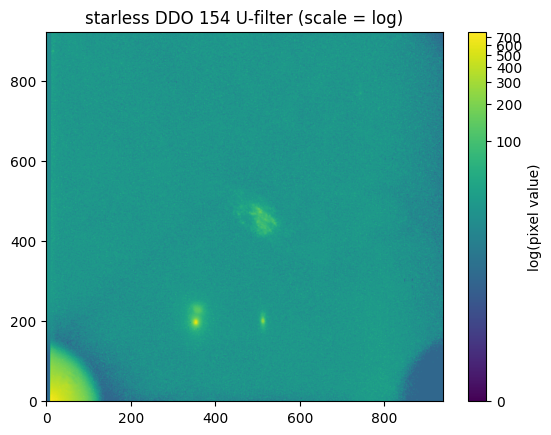

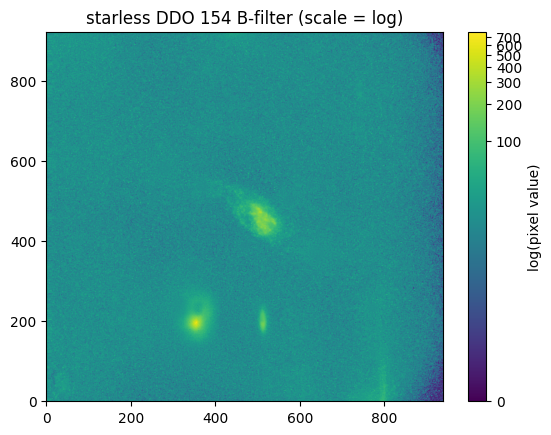

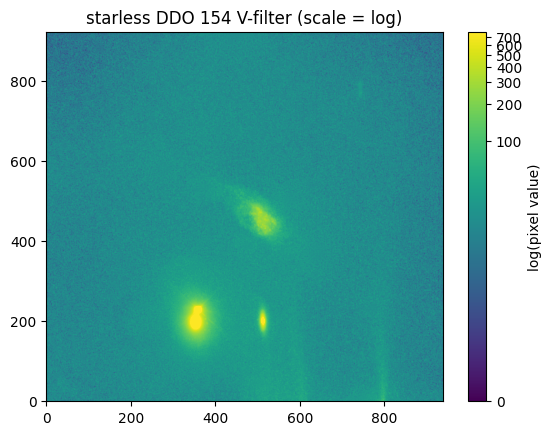

In [32]:
# import starless files----------------------------------------------------------------------------------------------------------------------------------------------------
starless_file_u = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d154\DDO 154 starless\starless_DDO154_U_background_subtracted.fit")
starless_u = starless_file_u[0].data
starless_u[starless_u <= 0] = 1
starless_file_b = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d154\DDO 154 starless\starless_DDO154_B_background_subtracted.fit")
starless_b = starless_file_b[0].data
starless_b[starless_b <= 0] = 1
starless_file_v = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d154\DDO 154 starless\starless_DDO154_V_background_subtracted.fit")
starless_v = starless_file_v[0].data
starless_v[starless_v <= 0] = 1

starless = [starless_u , starless_b , starless_v]

norm = ImageNormalize(vmin=0., stretch=LogStretch())


for i in range(0 , len(starless)):
    
    plt.imshow(starless[i] , origin = "lower" , aspect='auto', norm = norm)
    plt.title('starless DDO 154 %s-filter (scale = log)'%(filters[i]))
    cbar = plt.colorbar()
    cbar.set_label('log(pixel value)')
    plt.show()

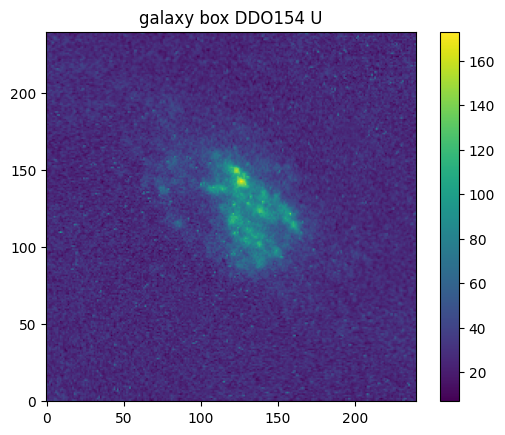

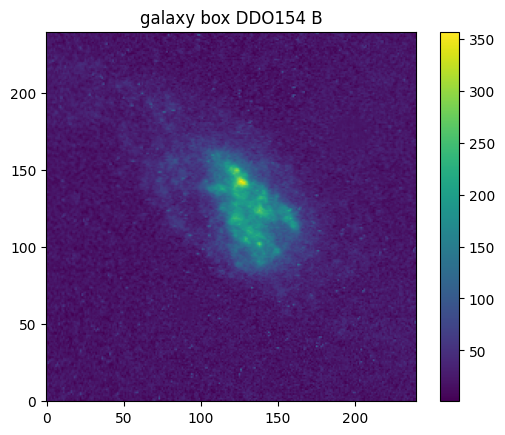

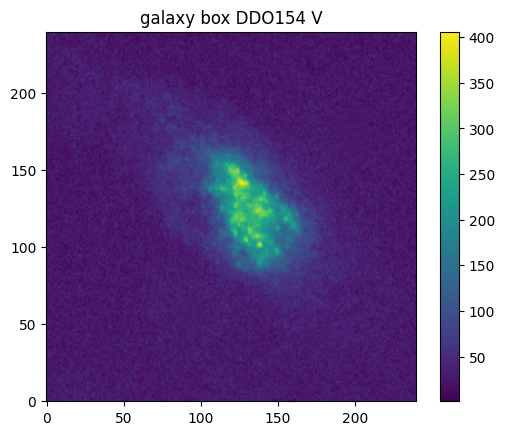

In [68]:
norm = ImageNormalize(vmin=0., stretch=LogStretch())
center = [500,450]
box_size = 120
# Slice the array
galaxy_boxes = []
for i in range(0 , len(starless)):
    galaxy_box = starless[i][center[1]-box_size : center[1]+box_size , center[0]-box_size : center[0]+box_size]
    galaxy_boxes.append(galaxy_box)
    plt.imshow(galaxy_box, origin = "lower")
    plt.title("galaxy box %s %s"%(galaxy_name,filters[i]))
    plt.colorbar()
    plt.show()
    '''
    image_center_of_mass = ndimage.center_of_mass(galaxy_box)
    #coordinates
    x, y = image_center_of_mass[1], image_center_of_mass[0]
    # Create a figure and axes
    fig, ax = plt.subplots()
    # Display  image
    ax.imshow(galaxy_box,norm=norm,origin="lower")
    plt.title("center of mass %s %s"%(galaxy_name,filter))
    # Mark the point with a red circle
    circle = plt.Circle((x, y), radius=1, fill=False, color='red')
    ax.add_patch(circle)
    plt.show() 
    '''

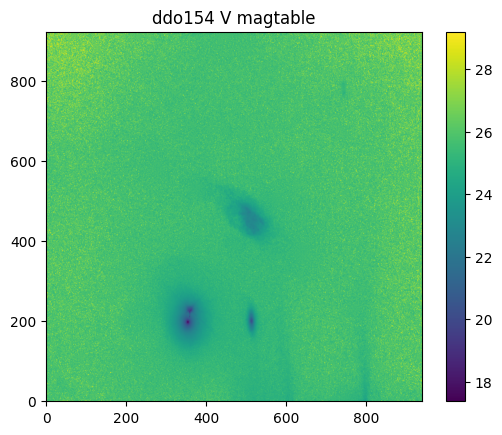

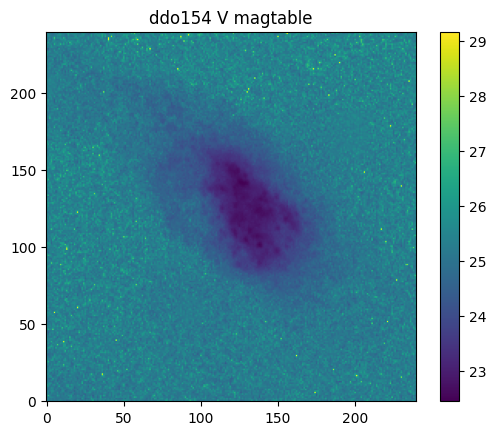

In [69]:
airmass_values=[1.16, 1.49, 1.11]
pixel_scale = 1.134
mU_values = [5.196, 0.4683865, -0.093,  0.]
mB_values = [3.562, 0.2586217, -0.0166, 0.]
mV_values = [3.017, 0.128904 ,  0.045,  0.]
m_values = [mU_values,mB_values,mV_values]

def mag_table_correction(images, airmass_values, m_values):
    #first step of mag correction (turning each pixel into a magnitude/arcsec value)
    magnitude_tables=[]
    for i in range(0,len(images)): 
        image = images[i]
        flux = (image/(exp[i]*((pixel_scale)**2)))
        magnitude_table = (-2.5 * np.log10(flux) + 25) 
        magnitude_tables.append(magnitude_table)
 
    corrected_magnitude_tables = []
    for i in range(0,len(magnitude_tables)):
        s1 = m_values[i][0]
        s2 = airmass_values[1]*m_values[i][1]
        s3=m_values[i][2]*(magnitude_tables[1] - magnitude_tables[2])
        s4=airmass_values[1]*m_values[i][3]*(magnitude_tables[1] - magnitude_tables[2])
        corrected_magnitude_table = magnitude_tables[i] - s1 - s2 - s3 - s4
        corrected_magnitude_tables.append(corrected_magnitude_table)
      
    return corrected_magnitude_tables

plt.imshow(mag_table_correction(starless,airmass_values,m_values)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

plt.imshow(mag_table_correction(galaxy_boxes,airmass_values,m_values)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

V_mag_box = mag_table_correction(galaxy_boxes,airmass_values,m_values)[2]

(120.08026996313289, 122.74450822873484)


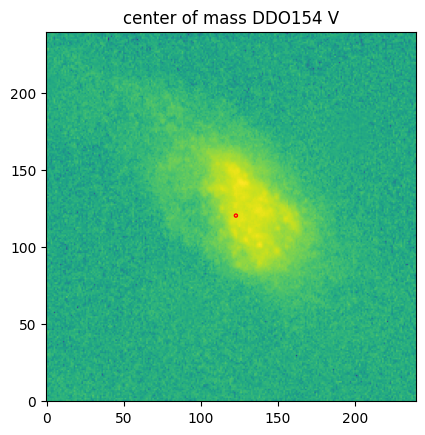

In [70]:
image_center_of_mass = ndimage.center_of_mass(galaxy_boxes[2])
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]
    
# Create a figure and axes
fig, ax = plt.subplots()
# Display  image
ax.imshow(galaxy_box,norm=norm,origin="lower")
plt.title("center of mass %s %s"%(galaxy_name,filters[2]))
# Mark the point with a red circle
circle = plt.Circle((x, y), radius=1, fill=False, color='red')
ax.add_patch(circle)
plt.show() 

[124.56643865 129.52369903  89.35985571  44.4920904    5.49550025]


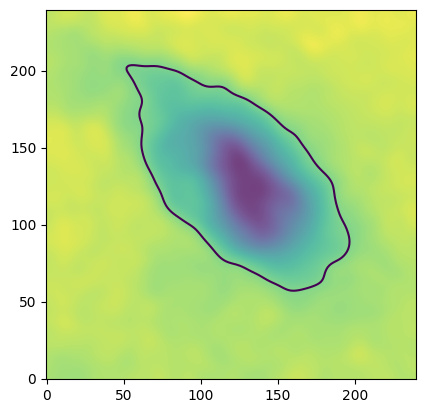

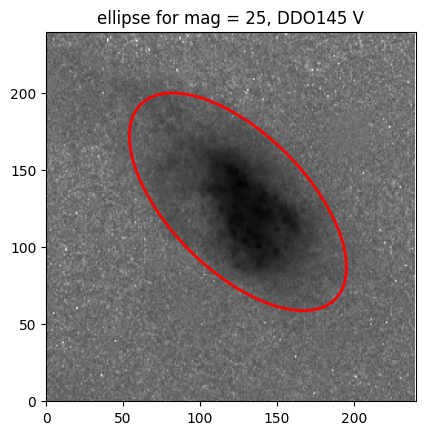

In [74]:
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
center_of_ellipse = image_center_of_mass

def contour_lines(box,sigma,level):
    #smoothing (gaussian convolution)----------------------------------------------------------------------------------------------
        smoothed = gaussian_filter(box, sigma)
        '''
        plt.imshow(smoothed, origin = "lower")
        plt.title("smoothed galaxy box %s %s"%(galaxy_name,filter[i]))
        plt.colorbar()
        plt.show()
        '''
        # Draw contour lines-----------------------------------------------------------------------------------------------------------
        # Plot the smoothed array
        plt.imshow(smoothed, alpha = 0.75 , origin = "lower")
        # Add contour line on top of the smoothed array
        CS = plt.contour(smoothed, level)
        dat0 = CS.allsegs[0][0]
        x_coord = dat0[:, 0]
        y_coord = dat0[:, 1]
        '''
        plt.plot(dat0[:, 0], dat0[:, 1])
        plt.show()
        # Set the title
        ax.set_title("Contours for %s V for contour %s" % (galaxy_name,level))
        # Display the plot
        plt.show()
        '''

        return x_coord,y_coord


contour = contour_lines(V_mag_box,sigma=5,level=[25])
x_points = contour[0]
y_points = contour[1]

def ellipse(x, xc, yc, a, b, theta):
    return ((x[0] - xc) * np.cos(theta) + (x[1] - yc) * np.sin(theta))**2 / a**2 + ((x[0] - xc) * np.sin(theta) - (x[1] - yc) * np.cos(theta))**2 / b**2 - 1

initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]

popt, pcov = curve_fit(ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

from matplotlib.patches import Ellipse

# Assuming you have already defined xc, yc, a, b, and theta
xc, yc, a, b, theta = popt
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(V_mag_box, cmap='gray' , origin = "lower")

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)

# Set axis limits (adjust as needed)
ax.set_xlim(0, V_mag_box.shape[1])
ax.set_ylim(0,V_mag_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for mag = 25, DDO145 V")
# Show the plot
plt.show()
